## Run Clay v1 on Planet Data

This adapts the [intro notebook](https://clay-foundation.github.io/model/tutorials/clay-v1-wall-to-wall.html) provided by Clay to work with PIP, and shows a quick example of getting embeddings for Planet Basemaps.


In [9]:
# Add the repo root to the sys path for the model import below
import sys

sys.path.append("model")

In [11]:
import math

import geopandas as gpd
import numpy as np
import pandas as pd
import torch
import yaml
from box import Box
from matplotlib import pyplot as plt
from shapely import Point
from sklearn import decomposition
from torchvision.transforms import v2

from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.sentinelhub import SentinelHub
from sentinelhub import SHConfig

from src.model import ClayMAEModule

In [13]:
# Configure sentinel hub credentials
config = SHConfig()
sh = SentinelHub(
    client_id=config.sh_client_id, 
    client_secret=config.sh_client_secret,
    error_handler=lambda resp: print(resp.text)
)

### Specify location and date of interest
In this example we will use a location in Portugal where a forest fire happened. We will run the model over the time period of the fire and analyse the model embeddings.

In [1]:
# Collection to use (this is the collection ID for Planet Basemaps)
collection_id = "byoc-c48c018f-67a1-4827-a1e4-f3ab98690312"

# Point in Brasil
lat, lon = -7.09093, -52.87102

# Dates of deforestation
start = "2022-05-01"
end = "2023-05-01"

# Local EPSG (has to be in meters)
epsg = "EPSG:32722"

### Create a bounding box around the point of interest

This is needed in the projection of the data so that we can generate image chips of the right size.

In [15]:
# Convert point of interest into the image projection
# (assumes all images are in the same projection)
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

# Create bounds in projection
size = 256
gsd = 5
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

### Get data as a datacube

See docstring here for more info: https://github.com/xcube-dev/xcube-sh/blob/main/xcube_sh/config.py#L38

In [16]:
cube_config = CubeConfig(
    collection_id=collection_id,
    band_names=["red", "green", "blue", "nir"],
    tile_size=[size, size],
    bbox=bounds,
    crs=epsg,
    spatial_res=gsd,
    time_range=[start, end],
    time_tolerance="1D",
    four_d=True,
)

In [17]:
stack = open_cube(
    cube_config, 
    sentinel_hub=sh
).band_data.compute()
stack

/home/jviehweger/micromamba/envs/clay/lib/python3.11/site-packages/xcube_sh/sentinelhub.py:254: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(dt, infer_datetime_format=True, utc=True)
/home/jviehweger/micromamba/envs/clay/lib/python3.11/site-packages/xcube_sh/sentinelhub.py:317: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  pd.to_timedelta(max_timedelta)


<xarray.DataArray 'band_data' (time: 12, y: 256, x: 256, band: 4)> Size: 13MB
array([[[[ 229.,  379.,  178., 3948.],
         [ 216.,  347.,  160., 3850.],
         [ 182.,  315.,  142., 3773.],
         ...,
         [ 128.,  290.,  107., 3333.],
         [ 126.,  289.,  102., 3399.],
         [ 113.,  275.,  104., 3124.]],

        [[ 240.,  379.,  188., 3864.],
         [ 206.,  339.,  163., 3849.],
         [ 180.,  309.,  145., 3827.],
         ...,
         [ 139.,  319.,  108., 3526.],
         [ 129.,  291.,   97., 3431.],
         [ 112.,  264.,  107., 3186.]],

        [[ 241.,  367.,  193., 3744.],
         [ 195.,  333.,  181., 3807.],
         [ 178.,  295.,  142., 3763.],
         ...,
...
         ...,
         [1252.,  836.,  451., 2324.],
         [1302.,  867.,  473., 2378.],
         [1282.,  855.,  478., 2415.]],

        [[ 192.,  425.,  141., 3510.],
         [ 145.,  274.,  121., 2648.],
         [ 120.,  247.,  114., 2535.],
         ...,
         [1223.,  806.,  444., 2309.],
         [1315.,  873.,  471., 2391.],
         [1334.,  876.,  487., 2463.]],

        [[ 197.,  452.,  156., 3439.],
         [ 154.,  288.,  123., 2630.],
         [ 112.,  223.,  107., 2256.],
         ...,
         [1222.,  813.,  453., 2327.],
         [1312.,  891.,  483., 2385.],
         [1371.,  918.,  498., 2452.]]]], dtype=float32)
Coordinates:
  * band     (band) <U5 80B 'red' 'green' 'blue' 'nir'
  * time     (time) datetime64[ns] 96B 2022-05-01 2022-06-01 ... 2023-04-01
  * x        (x) float64 2kB 2.927e+05 2.927e+05 2.927e+05 ... 2.94e+05 2.94e+05
  * y        (y) float64 2kB 9.216e+06 9.216e+06 ... 9.215e+06 9.215e+06
Attributes:
    band_names:    ['red', 'green', 'blue', 'nir']
    grid_mapping:  crs

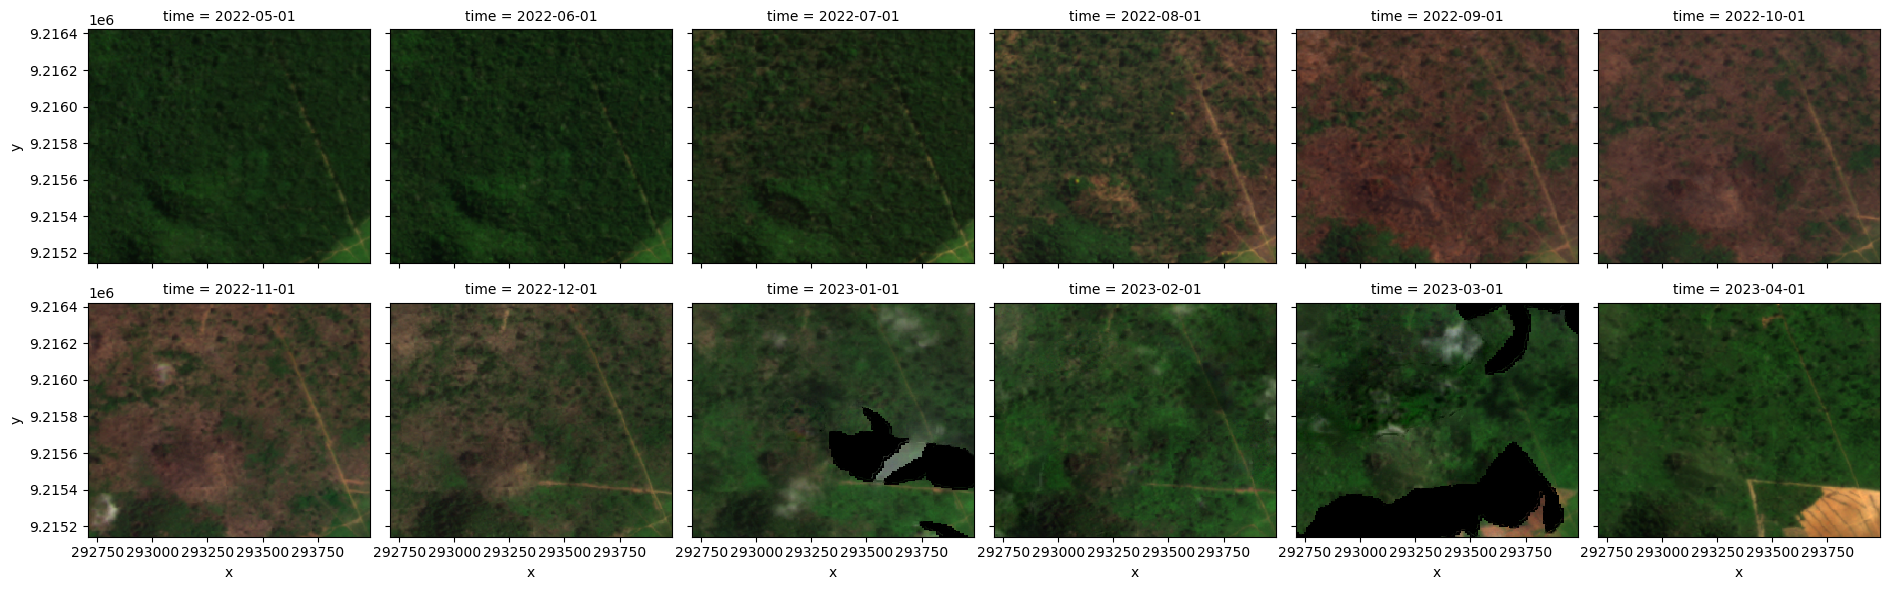

In [18]:
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

### Load the model

We now have the data to analyse, let's load the model.

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="model/configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

/home/jviehweger/micromamba/envs/clay/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Prepare band metadata for passing it to the model

This is the most technical part so far. We will take the information in the stack of imagery and convert it into the formate that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

The Clay model will accept any band combination in any order, from different platforms. But for this the model needs to know the wavelength of each band that is passed to it, and normalization parameters for each band as well. It will use that to normalize the data and to interpret each band based on its central wavelength.

For Sentinel-2 we can use medata file of the model to extract those values. But this cloud also be something custom for a different platform.

In [21]:
# Extract mean, std, and wavelengths from metadata
platform = "planetscope-sr"
metadata = Box(yaml.safe_load(open("model/configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in ["red", "green", "blue", "nir"]:
    mean.append(metadata[platform].bands.mean[str(band)])
    std.append(metadata[platform].bands.std[str(band)])
    waves.append(metadata[platform].bands.wavelength[str(band)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

In [22]:
transform

Compose(    Normalize(mean=[2290.0, 2088.0, 1715.0, 3970.0], std=[868.0, 768.0, 698.0, 914.0], inplace=False))

### Convert the band pixel data in to the format for the model

We will take the information in the stack of imagery and convert it into the formate that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

In [23]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(np.transpose(stack.data.astype(np.float32), (0,3,1,2)))
pixels = transform(pixels)

### Combine the metadata and the transformed pixels

Now we can combine all of these inputs into a dictionary that combines everything.

In [24]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(gsd, device=device),
    "waves": torch.tensor(waves, device=device),
}

### Run the model

Pass the datacube we prepared to the model to create embeddings. This will create one embedding vector for each of the images we downloaded.

In [17]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

In [18]:
embeddings

array([[ 0.07015692, -0.07723202, -0.09946313, ...,  0.0692978 ,
         0.23059581,  0.11423087],
       [ 0.05801073, -0.07465267, -0.09918004, ...,  0.08139849,
         0.2208287 ,  0.1186697 ],
       [ 0.00061569, -0.07262594, -0.10420966, ...,  0.08263881,
         0.20394285,  0.10136307],
       ...,
       [ 0.06110787, -0.08294784, -0.03988406, ...,  0.08577088,
         0.24127519,  0.08006233],
       [ 0.09758394, -0.05910278,  0.02355294, ...,  0.0475434 ,
         0.14182228,  0.10279381],
       [ 0.02473297, -0.10401113,  0.02862377, ...,  0.0191249 ,
         0.07682316,  0.09805395]], dtype=float32)

### Analyse the embeddings

A simple analysis of the embeddings is to reduce each one of them into a single number using Principal Component Analysis. For this we will fit a PCA on the 12 embeddings we have, and do the dimensionality reduction for them. We will se a separation into three groups, the previous images, the cloudy images, and the images after the fire, they all fall into a different range of the PCA space.

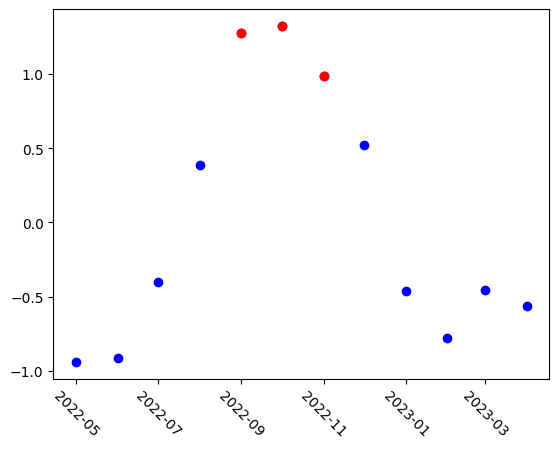

In [21]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

# Plot all points in blue first
plt.scatter(stack.time, pca_result, color="blue")

# Re-plot deforested images in red
plt.scatter(stack.time[4], pca_result[4], color="red")
plt.scatter(stack.time[5], pca_result[5], color="red")
plt.scatter(stack.time[6], pca_result[6], color="red")